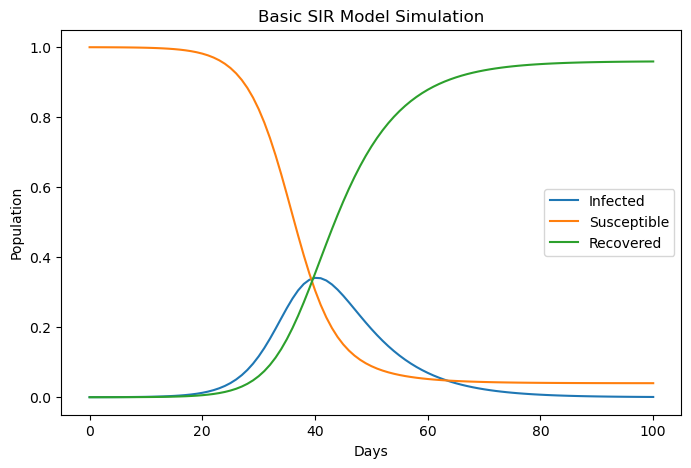

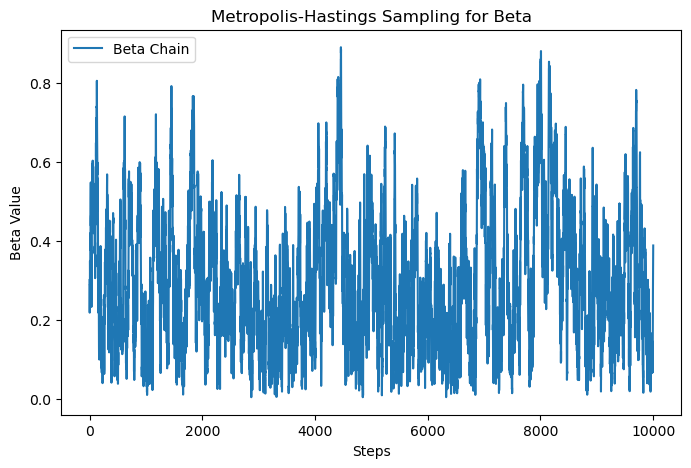

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


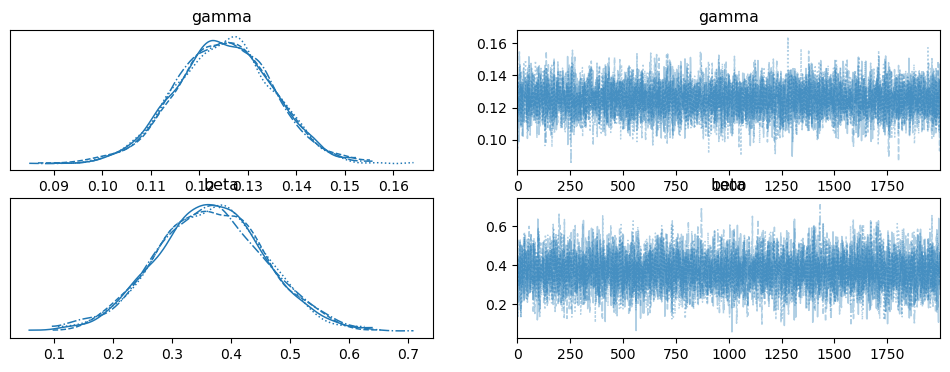

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as stats

def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100):
    """ Simulate a basic SIR model using given parameters """
    S, I, R = [N - I0], [I0], [0]
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new = I[-1] + (beta * S[-1] * I[-1] / N - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R)

# Simulating the model
N = 1e6
I0 = 100
beta = 0.4  # Spreading rate
gamma = 1/8  # Recovery rate
days = 100
S, I, R = simulate_basic_SIR(N, I0, beta, gamma, days)

# Plot the basic model results
plt.figure(figsize=(8,5))
plt.plot(I/N, label="Infected")
plt.plot(S/N, label="Susceptible")
plt.plot(R/N, label="Recovered")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("Basic SIR Model Simulation")
plt.show()

# Custom Metropolis-Hastings Algorithm for Parameter Inference
def metropolis_hastings(log_prob, init, steps=5000, scale=0.02):
    """ Implements a simple Metropolis-Hastings algorithm """
    chain = [init]
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale)
        if np.random.rand() < np.exp(log_prob(proposal) - log_prob(chain[-1])):
            chain.append(proposal)
        else:
            chain.append(chain[-1])
    return np.array(chain)

# Defining the log-probability function (example: Beta distribution prior)
def log_prob(beta):
    if beta <= 0 or beta > 1:
        return -np.inf  # Enforce bounds
    return stats.beta.logpdf(beta, 2, 5)  # Prior distribution

# Running Metropolis-Hastings
beta_chain = metropolis_hastings(log_prob, init=0.3, steps=10000, scale=0.05)

# Plot Metropolis-Hastings samples
plt.figure(figsize=(8,5))
plt.plot(beta_chain, label="Beta Chain")
plt.xlabel("Steps")
plt.ylabel("Beta Value")
plt.legend()
plt.title("Metropolis-Hastings Sampling for Beta")
plt.show()

# Bayesian Inference with PyMC3 (using NUTS)
with pm.Model() as model:
    beta = pm.Beta("beta", alpha=2, beta=5)
    gamma = pm.Normal("gamma", mu=1/8, sigma=0.01)
    likelihood = pm.Normal("obs", mu=beta, sigma=0.1, observed=0.4)
    trace = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

# Plot Bayesian inference results
pm.plot_trace(trace)
plt.show()


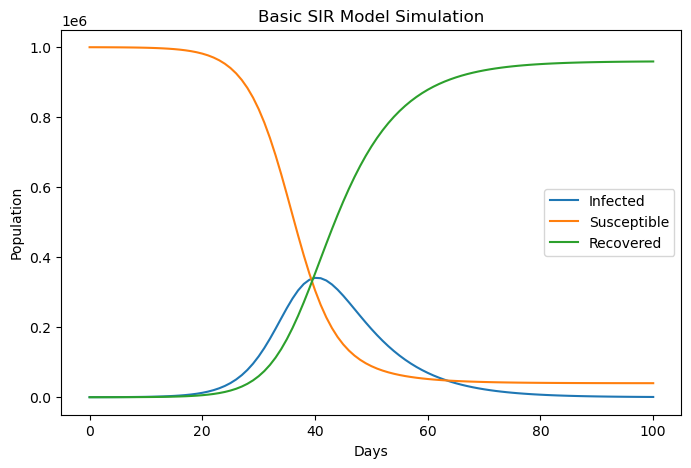

Acceptance rate: 0.49


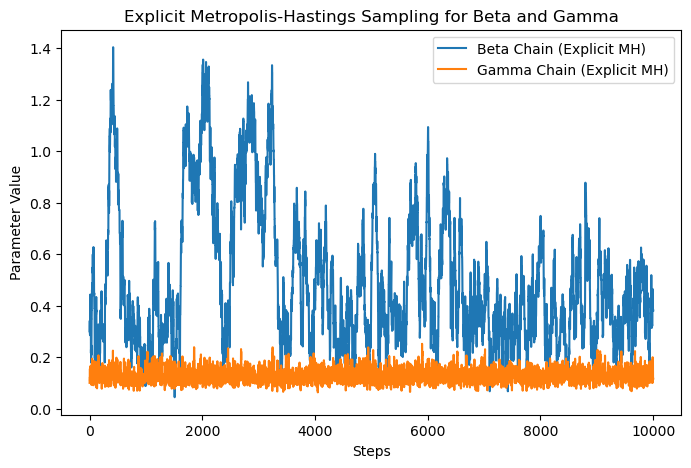

0.12832745240229304
0.4924638145137362


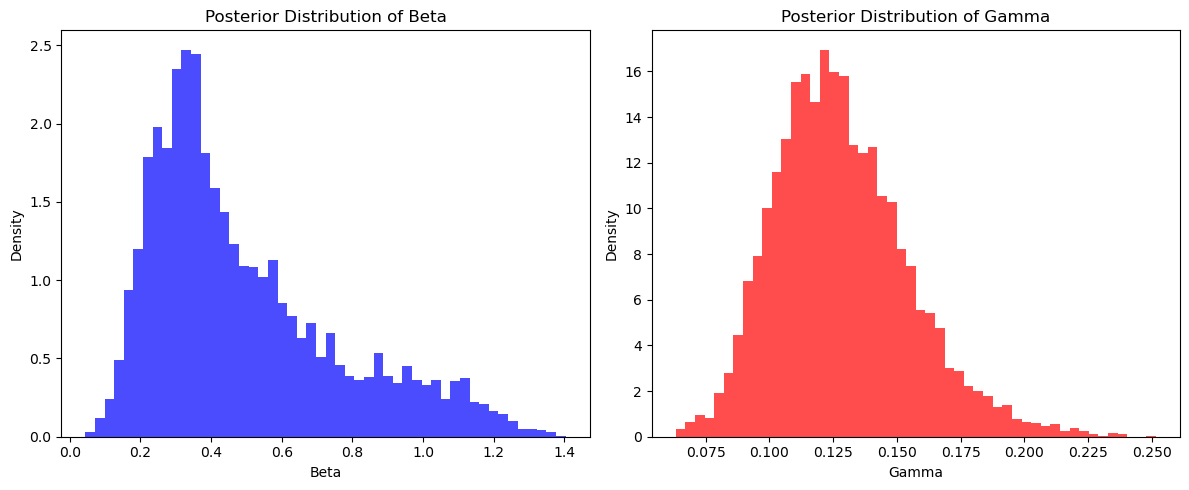

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100):
    """ Simulate a basic SIR model using given parameters """
    S, I, R = [N - I0], [I0], [0]
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new = I[-1] + (beta * S[-1] * I[-1] / N - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R)

# Simulating the model
N = 1e6
I0 = 100
beta = 0.4  # Spreading rate
gamma = 1/8  # Recovery rate
days = 100
S, I, R = simulate_basic_SIR(N, I0, beta, gamma, days)

# Plot the basic model results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected")
plt.plot(S, label="Susceptible")
plt.plot(R, label="Recovered")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("Basic SIR Model Simulation")
plt.show()

# Explicit Metropolis-Hastings Algorithm for Parameter Inference
def metropolis_hastings_explicit(log_prob, init, steps=5000, scale=0.02):
    """ Implements an explicit Metropolis-Hastings algorithm """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale)
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Defining the log-probability function for beta and gamma
def log_prob_params(params):
    beta, gamma = params
    if beta <= 0 or gamma <= 0:  # La lognormale è definita solo per valori positivi
        return -np.inf  

    sigma_beta = 0.5  # Deviazione standard nel dominio logaritmico
    sigma_gamma=0.2
    mu_beta = np.log(0.4)  # Media logaritmica per beta
    mu_gamma = np.log(1/8)  # Media logaritmica per gamma

    return stats.lognorm.logpdf(beta, s=sigma_beta, scale=np.exp(mu_beta)) + \
           stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma))


# Running Explicit Metropolis-Hastings for beta and gamma
def metropolis_hastings_2d(log_prob, init, steps=5000, scale=0.02):
    """ Implements Metropolis-Hastings for two parameters """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=2)
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Running Explicit Metropolis-Hastings
param_chain = metropolis_hastings_2d(log_prob_params, init=np.array([0.3, 0.1]), steps=10000, scale=0.05)



# Plot Explicit Metropolis-Hastings samples
plt.figure(figsize=(8,5))
plt.plot(param_chain[:, 0], label="Beta Chain (Explicit MH)")
plt.plot(param_chain[:, 1], label="Gamma Chain (Explicit MH)")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.title("Explicit Metropolis-Hastings Sampling for Beta and Gamma")
plt.show()


#print(param_chain[:,1])
print(np.mean(param_chain[:,1]))
print(np.mean(param_chain[:,0]))

# Plot probability distributions for beta and gamma
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(param_chain[:, 0], bins=50, density=True, alpha=0.7, color='b')
plt.xlabel("Beta")
plt.ylabel("Density")
plt.title("Posterior Distribution of Beta")

plt.subplot(1,2,2)
plt.hist(param_chain[:, 1], bins=50, density=True, alpha=0.7, color='r')
plt.xlabel("Gamma")
plt.ylabel("Density")
plt.title("Posterior Distribution of Gamma")

plt.tight_layout()
plt.show()

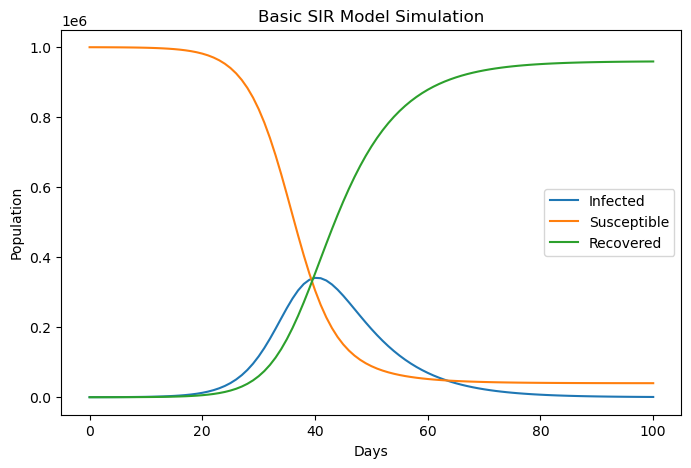

Acceptance rate: 0.47


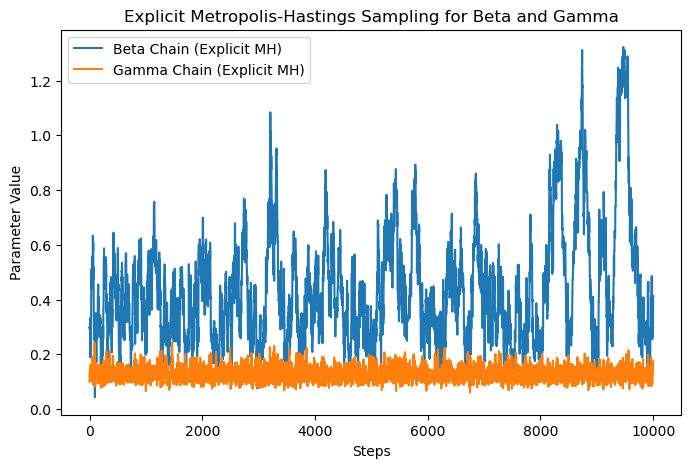

0.12844137784289644
0.4377676826262459


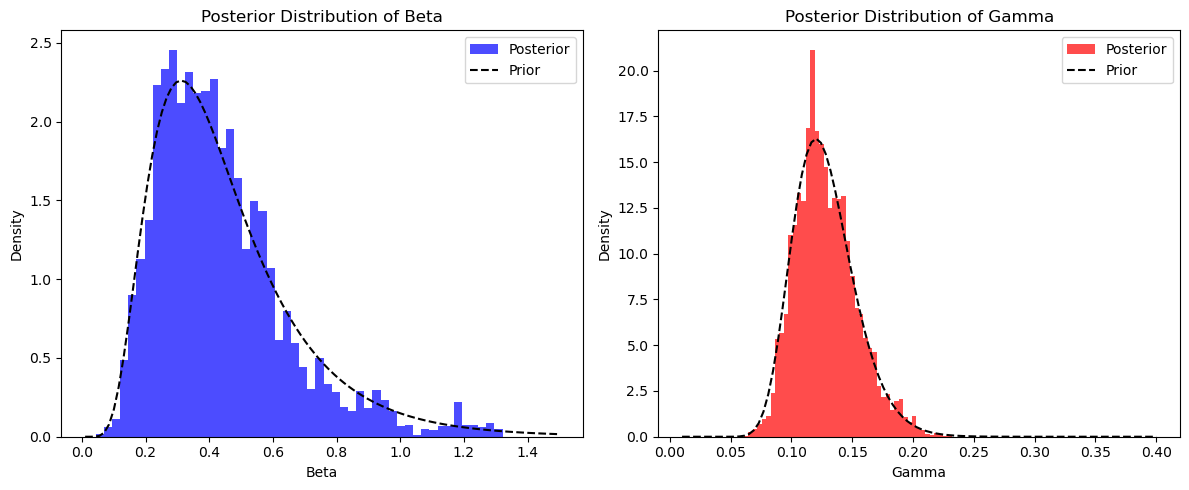

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100):
    """ Simulate a basic SIR model using given parameters """
    S, I, R = [N - I0], [I0], [0]
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new = I[-1] + (beta * S[-1] * I[-1] / N - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R)

# Simulating the model
N = 1e6
I0 = 100
beta = 0.4  # Spreading rate
gamma = 1/8  # Recovery rate
days = 100
S, I, R = simulate_basic_SIR(N, I0, beta, gamma, days)

# Plot the basic model results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected")
plt.plot(S, label="Susceptible")
plt.plot(R, label="Recovered")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("Basic SIR Model Simulation")
plt.show()

# Explicit Metropolis-Hastings Algorithm for Parameter Inference
def metropolis_hastings_explicit(log_prob, init, steps=5000, scale=0.02):
    """ Implements an explicit Metropolis-Hastings algorithm """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale)
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Defining the log-probability function for beta and gamma
def log_prob_params(params):
    beta, gamma = params
    if beta <= 0 or gamma <= 0:
        return -np.inf  
    sigma_beta = 0.5
    sigma_gamma = 0.2
    mu_beta = np.log(0.4)
    mu_gamma = np.log(1/8)
    return stats.lognorm.logpdf(beta, s=sigma_beta, scale=np.exp(mu_beta)) + \
           stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma))

# Running Explicit Metropolis-Hastings for beta and gamma
def metropolis_hastings_2d(log_prob, init, steps=5000, scale=0.02):
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=2)
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Running Explicit Metropolis-Hastings
param_chain = metropolis_hastings_2d(log_prob_params, init=np.array([0.3, 0.1]), steps=10000, scale=0.05)

# Plot Explicit Metropolis-Hastings samples
plt.figure(figsize=(8,5))
plt.plot(param_chain[:, 0], label="Beta Chain (Explicit MH)")
plt.plot(param_chain[:, 1], label="Gamma Chain (Explicit MH)")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.title("Explicit Metropolis-Hastings Sampling for Beta and Gamma")
plt.show()

print(np.mean(param_chain[:,1]))
print(np.mean(param_chain[:,0]))

# Plot probability distributions for beta and gamma with priors
x_beta = np.linspace(0.01, 1.5, 100)
prior_beta = stats.lognorm.pdf(x_beta, s=0.5, scale=np.exp(np.log(0.4)))

x_gamma = np.linspace(0.01, 0.4, 100)
prior_gamma = stats.lognorm.pdf(x_gamma, s=0.2, scale=np.exp(np.log(1/8)))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(param_chain[:, 0], bins=50, density=True, alpha=0.7, color='b', label="Posterior")
plt.plot(x_beta, prior_beta, 'k--', label="Prior")
plt.xlabel("Beta")
plt.ylabel("Density")
plt.title("Posterior Distribution of Beta")
plt.legend()

plt.subplot(1,2,2)
plt.hist(param_chain[:, 1], bins=50, density=True, alpha=0.7, color='r', label="Posterior")
plt.plot(x_gamma, prior_gamma, 'k--', label="Prior")
plt.xlabel("Gamma")
plt.ylabel("Density")
plt.title("Posterior Distribution of Gamma")
plt.legend()

plt.tight_layout()
plt.show()


Acceptance rate: 0.48


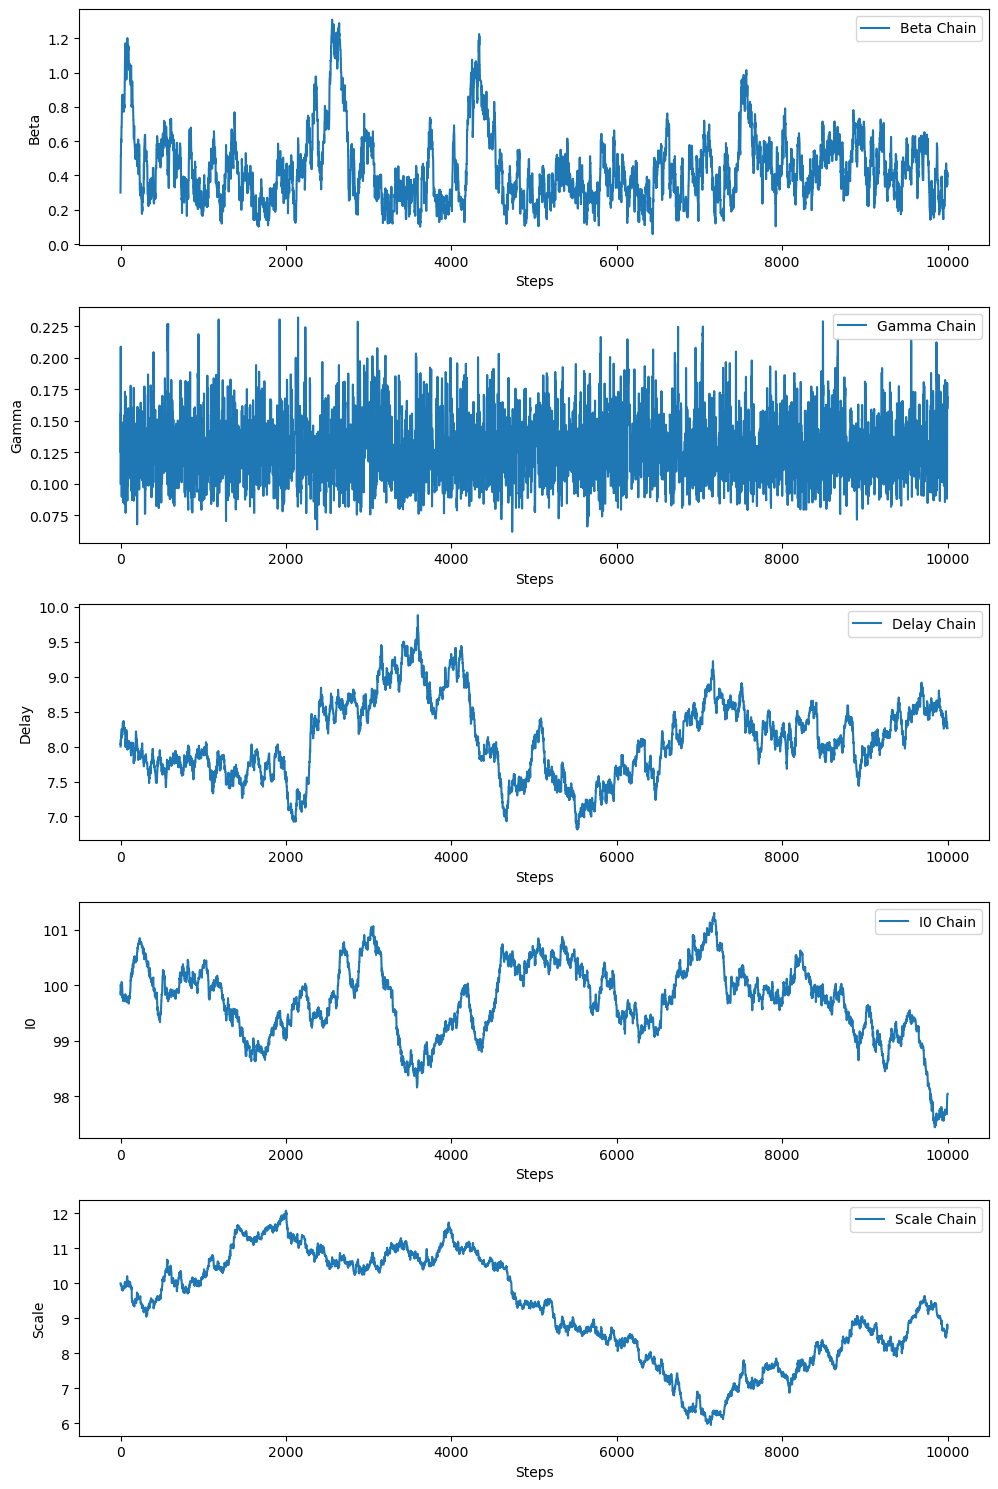

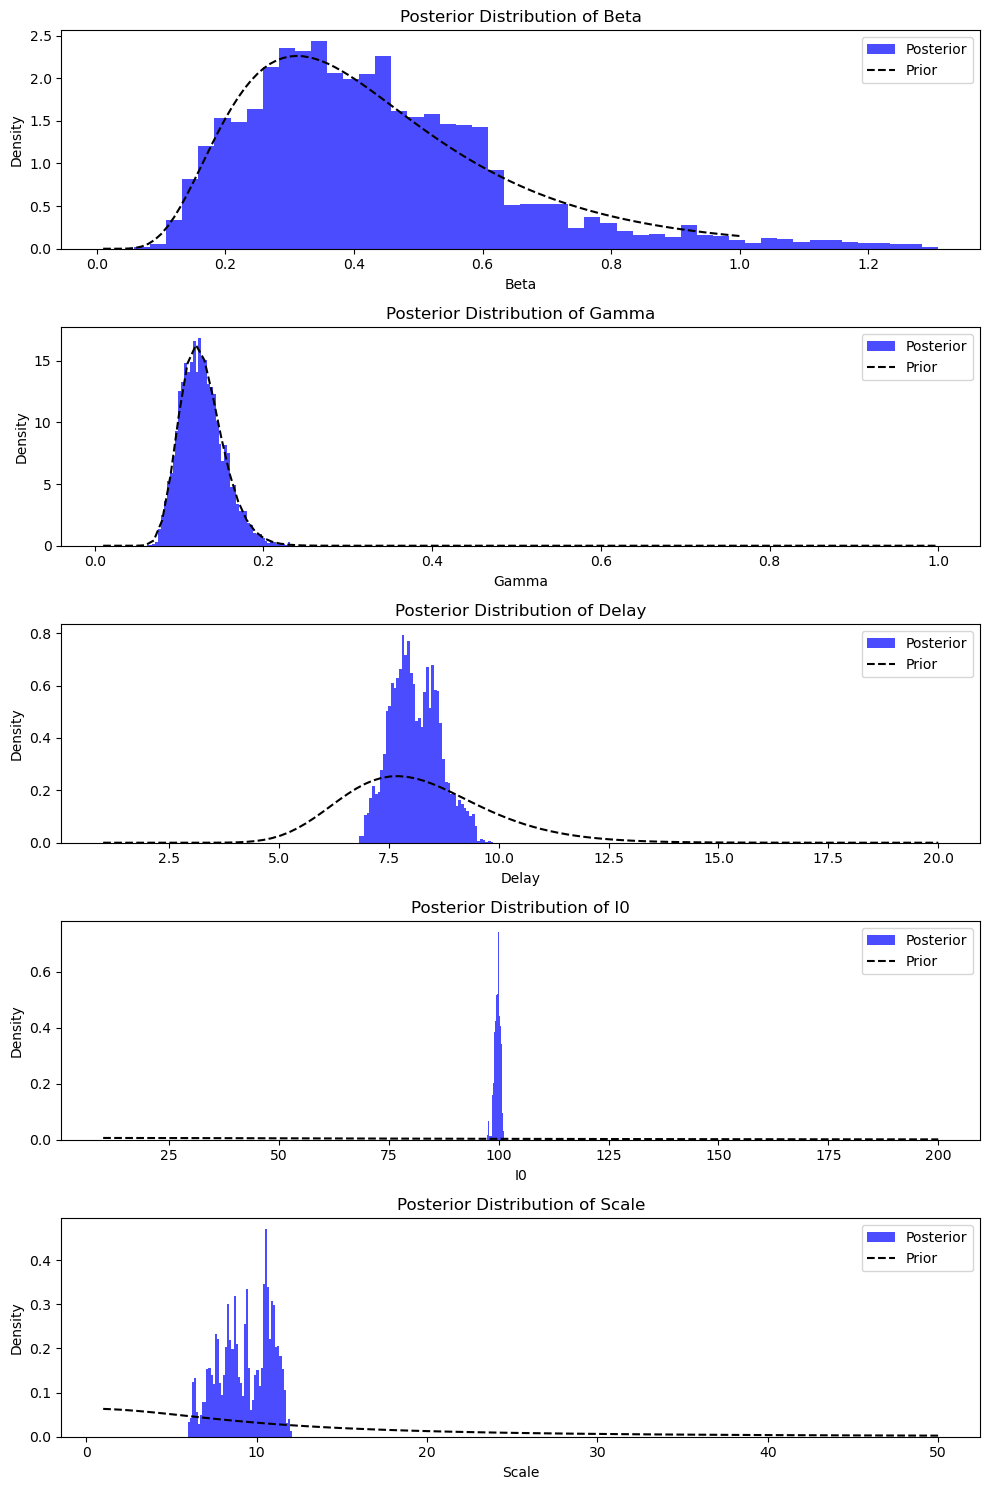

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100, delay=5):
    """ Simulate a basic SIR model using given parameters with reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else 0
        I_new_final = I[-1] + (I_new_t - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10

# Defining the log-probability function for beta, gamma, delay, I0, and scale
def log_prob_params(params):
    beta, gamma, delay, I0, scale = params
    if beta <= 0 or gamma <= 0 or delay <= 0 or I0 <= 0 or scale <= 0:
        return -np.inf  
    return (stats.lognorm.logpdf(beta, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale))

# Running Explicit Metropolis-Hastings for multiple parameters
def metropolis_hastings_multi(log_prob, init, steps=5000, scale=0.02):
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Running Explicit Metropolis-Hastings
param_chain = metropolis_hastings_multi(log_prob_params, init=np.array([0.3, 0.1, 8, 100, 10]), steps=10000, scale=0.05)

# Plot parameter chains
labels = ["Beta", "Gamma", "Delay", "I0", "Scale"]
plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(param_chain[:, i], label=f"{labels[i]} Chain")
    plt.xlabel("Steps")
    plt.ylabel(f"{labels[i]}")
    plt.legend()
plt.tight_layout()
plt.show()

# Plot probability distributions with priors
x_vals = [np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100), np.linspace(1, 20, 100), np.linspace(10, 200, 100), np.linspace(1, 50, 100)]
priors = [stats.lognorm.pdf(x_vals[0], s=sigma_beta, scale=np.exp(mu_beta)),
          stats.lognorm.pdf(x_vals[1], s=sigma_gamma, scale=np.exp(mu_gamma)),
          stats.lognorm.pdf(x_vals[2], s=sigma_delay, scale=np.exp(mu_delay)),
          stats.halfcauchy.pdf(x_vals[3], scale=sigma_I0),
          stats.halfcauchy.pdf(x_vals[4], scale=sigma_scale)]

plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.hist(param_chain[:, i], bins=50, density=True, alpha=0.7, color='b', label="Posterior")
    plt.plot(x_vals[i], priors[i], 'k--', label="Prior")
    plt.xlabel(labels[i])
    plt.ylabel("Density")
    plt.title(f"Posterior Distribution of {labels[i]}")
    plt.legend()
plt.tight_layout()
plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma, delay, I0, scale]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


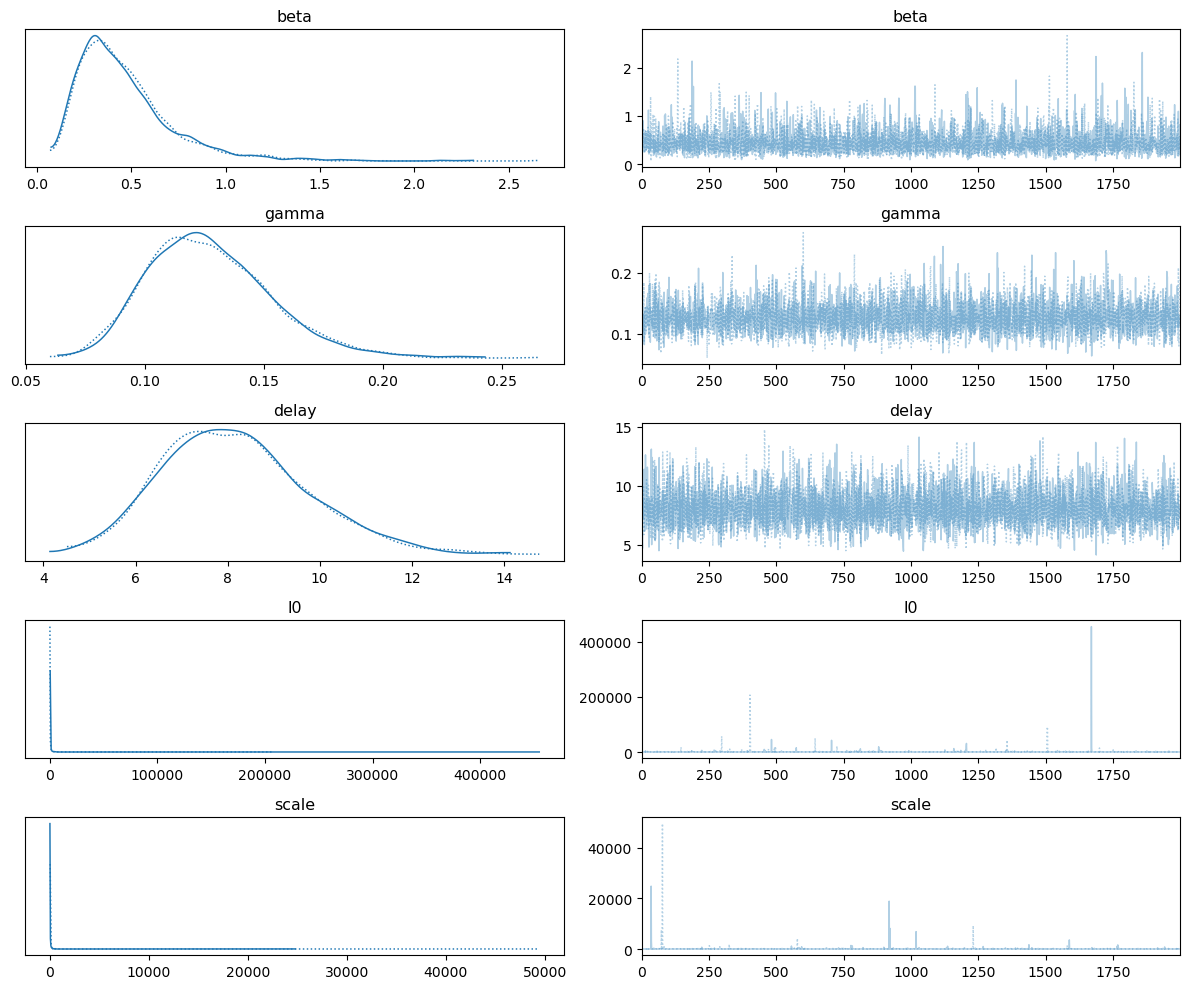

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100, delay=5):
    """ Simulate a basic SIR model using given parameters with reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else 0
        I_new_final = I[-1] + (I_new_t - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Priors for the parameters using PyMC
with pm.Model() as model:
    beta = pm.Lognormal("beta", mu=np.log(0.4), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot parameter posteriors with NUTS sampling
pm.plot_trace(trace)
plt.tight_layout()  # Regola automaticamente gli spazi tra i titoli
plt.show()



---

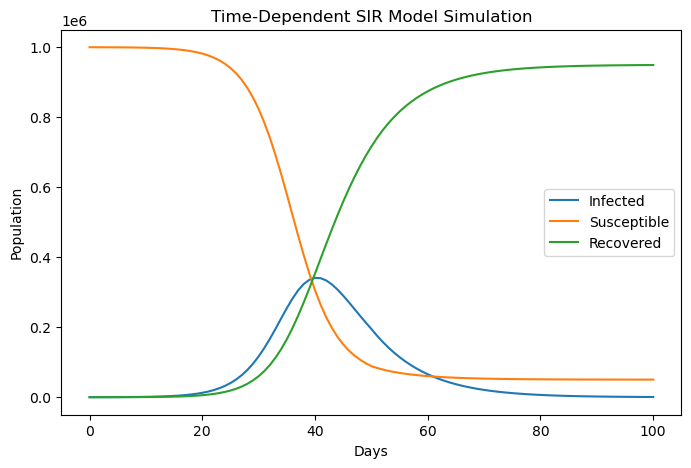

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta2, gamma]


Acceptance rate: 0.84


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


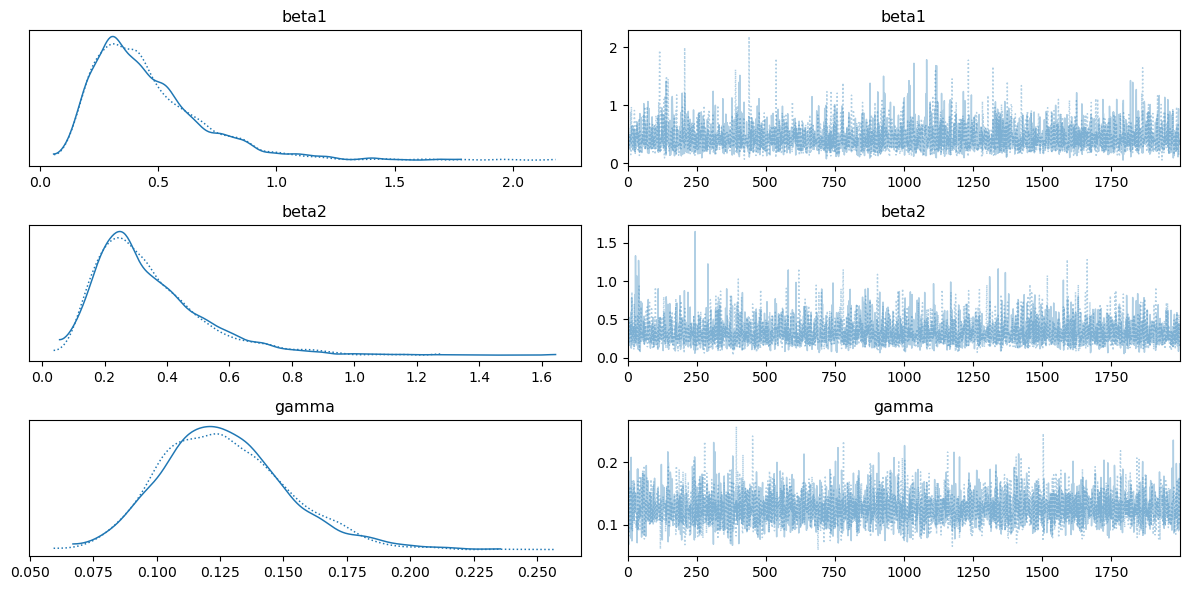

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as stats

def simulate_time_dependent_SIR(N=1e6, I0=100, beta_vals=[0.4, 0.3], gamma=1/8, days=100, switch_points=[50]):
    """ Simulate a time-dependent SIR model with one or more switch points """
    S, I, R = [N - I0], [I0], [0]
    dt = 1
    for t in range(days):
        beta = beta_vals[np.sum(t >= np.array(switch_points))]  # Use correct beta depending on time
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new = I[-1] + (beta * S[-1] * I[-1] / N - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R)

# Simulating the model with a switch point
N = 1e6
I0 = 100
beta_vals = [0.4, 0.3]  # Two different spreading rates
switch_points = [50]  # Switch at day 50
gamma = 1/8
days = 100
S, I, R = simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected")
plt.plot(S, label="Susceptible")
plt.plot(R, label="Recovered")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("Time-Dependent SIR Model Simulation")
plt.show()

# Metropolis-Hastings for time-dependent model
def metropolis_hastings_time_dependent(log_prob, init, steps=5000, scale=0.02):
    """ Implements Metropolis-Hastings for multiple parameters """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Log-probability function for time-dependent beta values
def log_prob_time_dependent(params):
    beta1, beta2 = params
    if beta1 <= 0 or beta2 <= 0:
        return -np.inf  
    return stats.lognorm.logpdf(beta1, s=0.5, scale=np.exp(np.log(0.4))) + \
           stats.lognorm.logpdf(beta2, s=0.5, scale=np.exp(np.log(0.3)))

# Running Metropolis-Hastings
param_chain = metropolis_hastings_time_dependent(log_prob_time_dependent, init=np.array([0.4, 0.3]), steps=10000, scale=0.05)

# Bayesian Inference using PyMC (NUTS)
with pm.Model() as model:
    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu=np.log(0.3), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot posterior distributions
pm.plot_trace(trace)
plt.tight_layout()
plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)


Acceptance rate: 0.86


NUTS: [beta1, beta2, gamma, delay, I0, scale]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


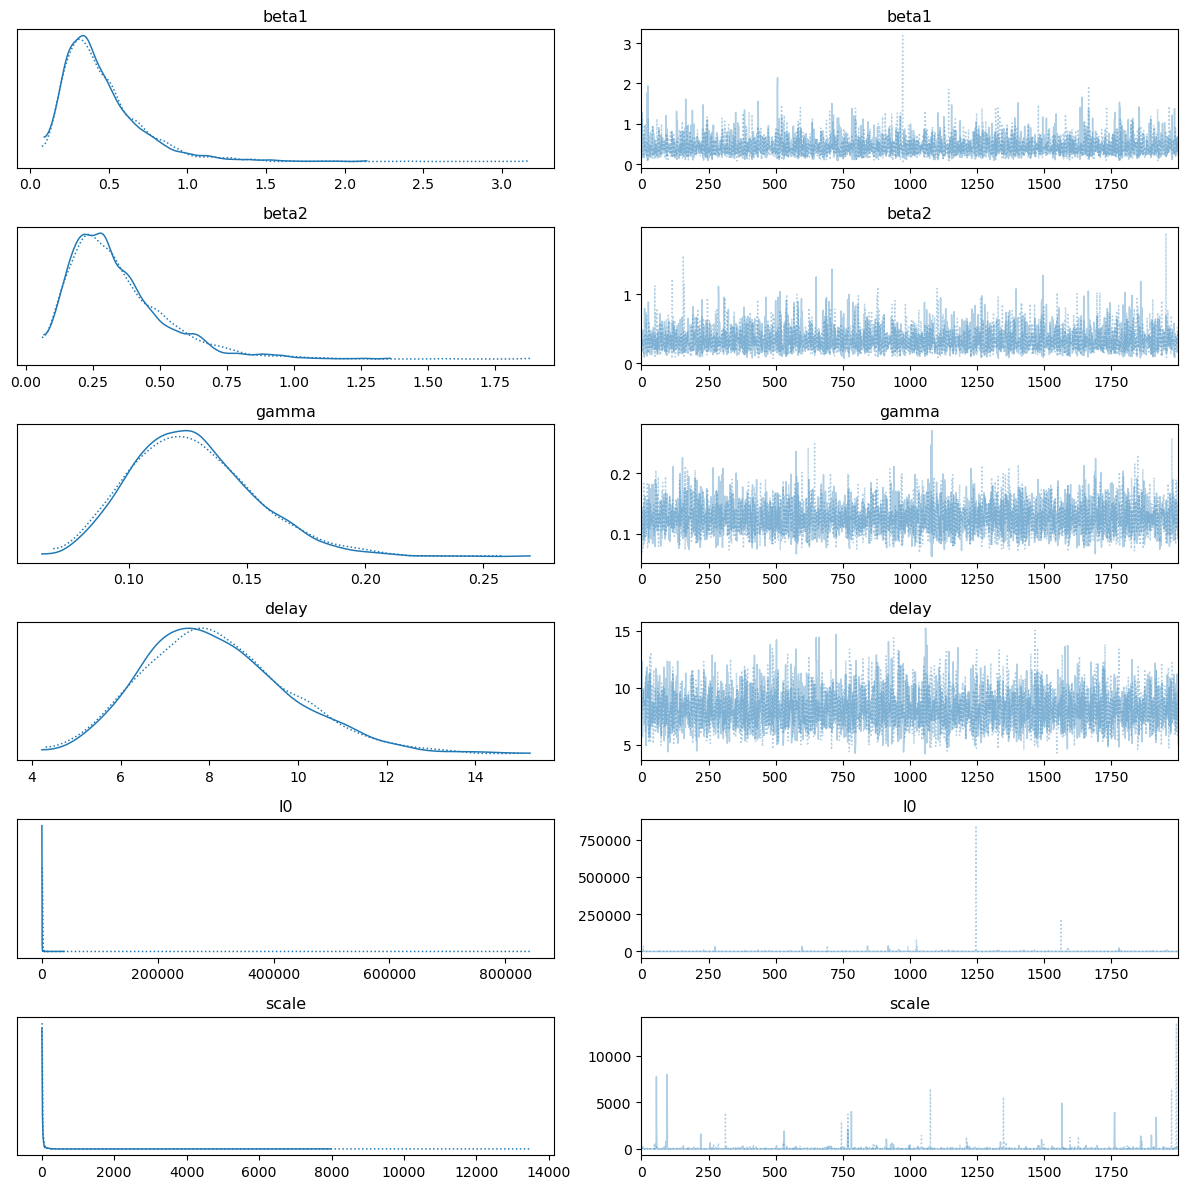

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as stats

def simulate_time_dependent_SIR(N=1e6, I0=100, beta_vals=[0.4, 0.3], gamma=1/8, days=100, switch_points=[50], delay=5):
    """ Simulate a time-dependent SIR model with one or more switch points and reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        beta = beta_vals[np.sum(t >= np.array(switch_points))]  # Use correct beta depending on time
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else 0
        I_new_final = I[-1] + (I_new_t - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Simulating the model with switch points and reporting delay
N = 1e6
I0 = 100
beta_vals = [0.4, 0.3]  # Two different spreading rates
switch_points = [50]  # Switch at day 50
gamma = 1/8
days = 100
delay = 5
S, I, R, I_new = simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay)

# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10

# Defining the log-probability function

def log_prob_time_dependent(params):
    beta1, beta2, delay, I0, scale = params
    if beta1 <= 0 or beta2 <= 0 or delay <= 0 or I0 <= 0 or scale <= 0:
        return -np.inf  
    return (stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(beta2, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale))

# Running Metropolis-Hastings
param_chain = metropolis_hastings_time_dependent(log_prob_time_dependent, init=np.array([0.4, 0.3, 8, 100, 10]), steps=10000, scale=0.05)

# Bayesian Inference using PyMC (NUTS)
with pm.Model() as model:
    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu=np.log(0.3), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot posterior distributions
pm.plot_trace(trace)
plt.tight_layout()
plt.show()
